In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)


In [3]:
# Loading the post EDA dataframe
df = pd.read_excel("df1.xlsx")

In [4]:
# Defining our x and y variables
x = df.drop(columns = [
                    "Churn_Yes",
                    "Unnamed: 0",
                   'OnlineSecurity_No internet service',
                   'OnlineBackup_No internet service',
                    'DeviceProtection_No internet service',
                   'TechSupport_No internet service',
                   'StreamingTV_No internet service',
                   'StreamingMovies_No internet service',
                   'MonthlyCharges',
                   'PhoneService_Yes',
                    'TotalCharges'
                   
                    
                   
                    
])

In [5]:
y = df["Churn_Yes"]

In [6]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size = 0.25, random_state= 25)

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['vif_value'] = [variance_inflation_factor(xtrain.values, i) for i in range(xtrain.shape[1])]
vif["features"] = xtrain.columns
vif.sort_values('vif_value', ascending=False)

,vif_value,features
20,7.445971,tenure
15,3.474922,Contract_Two year
6,3.151418,InternetService_Fiber optic
2,2.802996,Partner_Yes
12,2.663669,StreamingTV_Yes
7,2.653322,InternetService_No
16,2.651097,PaperlessBilling_Yes
13,2.645075,StreamingMovies_Yes
5,2.467035,MultipleLines_Yes
18,2.315973,PaymentMethod_Electronic check


In [8]:
from sklearn.ensemble import AdaBoostClassifier

In [9]:
adbc = AdaBoostClassifier()

In [10]:
?AdaBoostClassifier

In [11]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [12]:
params = {
    "n_estimators" : np.arange(0,501,50)
    
}
adbc_gs = GridSearchCV(adbc, param_grid=params, cv=10, verbose=True, n_jobs=-1)
adbc_gs.fit(xtrain,ytrain)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  1.6min finished


GridSearchCV(cv=10, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'n_estimators': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
             verbose=True)

In [13]:
adbc_gs.best_params_

{'n_estimators': 100}

In [14]:
adbc1 = AdaBoostClassifier(n_estimators=100)

In [15]:
adbc1.fit(xtrain,ytrain)

AdaBoostClassifier(n_estimators=100)

In [16]:
adbc1.score(xtrain,ytrain)

0.8096939915121734

In [17]:
adbc1.score(xtest,ytest)

0.7923643670462157

In [18]:
y_train_pred = adbc1.predict(xtrain)

In [19]:
y_test_pred = adbc1.predict(xtest)

In [20]:
from sklearn import metrics

In [21]:
print(metrics.classification_report(ytrain, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      3298
           1       0.67      0.54      0.60      1179

    accuracy                           0.81      4477
   macro avg       0.76      0.72      0.74      4477
weighted avg       0.80      0.81      0.80      4477



In [22]:
print(metrics.classification_report(ytest, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1095
           1       0.65      0.48      0.55       398

    accuracy                           0.79      1493
   macro avg       0.74      0.69      0.71      1493
weighted avg       0.78      0.79      0.78      1493



# Now we will predict the probability and set the cut off

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

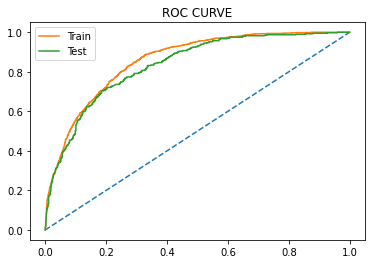

In [24]:
probs = adbc1.predict_proba(xtrain)[:,1]
probt = adbc1.predict_proba(xtest)[:,1]
fpr, tpr, thresholds = roc_curve(ytrain, probs)
fprt, tprt, thresholdst = roc_curve(ytest,probt)
plt.plot([0,1], [0,1], linestyle = "--")
plt.plot(fpr,tpr,label = "Train")
plt.plot(fprt,tprt, label = "Test")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [25]:
# Now we will find the AUC score
AUCs = roc_auc_score(ytrain,probs)
AUCt = roc_auc_score(ytest, probt)

print("AUC Score For Train Data {} \n AUC Score For Test Data {}".format(AUCs, AUCt))

AUC Score For Train Data 0.8572136915940007 
 AUC Score For Test Data 0.83568412840458


In [26]:
# Now we will find the optimum threshold of probability
optimum_thres_train = thresholds[np.argmax(tpr-fpr)]
optimum_thres_test  = thresholdst[np.argmax(tprt-fprt)]

print("Optimum Threshold Train Data : {} \n Optimum Threshold Test Data : {}".format(optimum_thres_train, optimum_thres_test))

Optimum Threshold Train Data : 0.4965576184084654 
 Optimum Threshold Test Data : 0.49851481241668794


In [27]:
# Now we will set the cut off
y_train_pred2 = np.where(probs <= 0.4965576184084654 , 0, 1)
y_test_pred2 = np.where(probt <= 0.4965576184084654 , 0, 1)

In [28]:
print(metrics.classification_report(ytrain, y_train_pred2))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      3298
           1       0.49      0.89      0.63      1179

    accuracy                           0.73      4477
   macro avg       0.72      0.78      0.71      4477
weighted avg       0.82      0.73      0.74      4477



In [29]:
print(metrics.classification_report(ytest, y_test_pred2))

              precision    recall  f1-score   support

           0       0.91      0.66      0.77      1095
           1       0.47      0.83      0.60       398

    accuracy                           0.71      1493
   macro avg       0.69      0.75      0.69      1493
weighted avg       0.80      0.71      0.72      1493



# FINAL RESULTS FOR THE TEST DATA
1. AUC Score = 0.8357
2. Accuracy  = 0.71
3. Precision = 0.47
4. Recall    = 0.83